In [1]:
from sys import path

In [2]:
path.append('/home/victor/work/Confirm/work/phy-sim/sionnaenv/lib/python3.8/site-packages/')

In [3]:
import sionna
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

Comms system description

* binary source
* data is transmitted in time slots containing 14 OFDM symbols
* LDPC encoded with user-defined code rate
* QAM 4 bits
* interleaving
* Rayleigh or CDL channel model - at the moment is hard-coded in the CommsSystem class
* support for ISI and ICI.

In [4]:
sionna.config.xla_compat = True

In [10]:
class CommsSystem(tf.keras.Model):
  def __init__(self, params):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=14, #params["num_ofdm_symbols"],
                          fft_size=72, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=params["cyclic_prefix_length"],
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined

    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    self.coderate = params["coderate"]
    self.num_bits_per_symbol = params["num_bits_per_symbol"]
    self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
    self.k = int(self.n*self.coderate)

    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth
                                            )
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
    self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                          row_depth=self.num_bits_per_symbol)
    self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
    self.modulator = sionna.ofdm.OFDMModulator(self.rg.cyclic_prefix_length)
    self.demodulator = sionna.ofdm.OFDMDemodulator(self.rg.fft_size,
                                                   self.l_min,
                                                   self.rg.cyclic_prefix_length)
    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder,
                                                 hard_out=True,
                                                 num_iter=50)
    
    # Use a Rayleigh channel
    # self.channel = sionna.channel.RayleighBlockFading(1, 1, 1, 1)
    # Use the CDL channel - which needs the antenna geometry
    """
    if channel == None:  
      carrier_frequency = 2.6e9
      _ut_array = sionna.channel.tr38901.AntennaArray(num_rows=1,
                                    num_cols=1,
                                    polarization="dual",
                                    polarization_type="cross",
                                    antenna_pattern="38.901",
                                    carrier_frequency=carrier_frequency)

      _bs_array = sionna.channel.tr38901.AntennaArray(num_rows=1,
                                    num_cols=1,
                                    polarization="dual",
                                    polarization_type="cross",
                                    antenna_pattern="38.901",
                                    carrier_frequency=carrier_frequency)    
      self.channel = sionna.channel.tr38901.CDL(model="A",
                                                delay_spread=100e-9,
                                                carrier_frequency=carrier_frequency,
                                                ut_array=_ut_array,
                                                bs_array=_bs_array,
                                                direction="uplink")
    else:
      self.channel = channel
    """
    if 'channel' in params:
        self.channel = params['channel']
    self.channel_time = sionna.channel.ApplyTimeChannel(self.rg.num_time_samples,
                                                        l_tot=self.l_tot,
                                                        add_awgn=True)
    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  def set_channel(self, ch):
    self.channel = ch
    
  @tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.coderate, self.rg)
    # Generate the bit vectors
    b = self.binary_source([batch_size, 1, 1, self.k])
    # Encode the bits
    c = self.encoder(b)
    # Interleave
    c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c_int)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)
    # OFDM modulation
    x_time = self.modulator(x_rg)

    # Generate CIRs from the channel
    cir = self.channel(batch_size, self.rg.num_time_samples+self.l_tot-1, self.bandwidth)
    # Convert to time channel
    h_time = sionna.channel.cir_to_time_channel(self.bandwidth,
                                                *cir,
                                                self.l_min, self.l_max,
                                                normalize=True)
    # Compute the channel output
    y_time = self.channel_time([x_time, h_time, no])
    # Demodulate
    y = self.demodulator(y_time)

    # TODO this is where we can distinguish between perfect/imperfect estimation

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    llr_int = self.deinterleaver(llr)
    # Decoding
    b_hat = self.decoder(llr_int)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return b, b_hat

Generate a dataset channel

In [6]:
gburg_cir = [0,0.476857537421572,
12.5,0.493390710409533,
25,0.738230286645292,
37.5,0.969836146969787,
50,0.79887736811687,
62.5,1,
75,0.93040719829778,
87.5,0.711218964780822,
100,0.826124299014998,
112.5,0.674280213167514,
125,0.487805164866206,
137.5,0.538017720435841,
150,0.43615619413265,
162.5,0.3011336502656,
175,0.330748101910841,
187.5,0.374497141938072,
200,0.486134959538253,
212.5,0.519823148738416,
225,0.45675882762224,
237.5,0.353749773109548,
250,0.241906646884643,
262.5,0.117252707765767,
275,0.0113846239299499,
287.5,0.122355857667484,
300,0.160032337592821,
312.5,0.26500699633174,
325,0.370213551400985,
337.5,0.399026631860705,
350,0.339895964115828,
362.5,0.246495252120125,
375,0.164585268364148,
387.5,0.13308504310719,
400,0.113295741696201,
412.5,0.100417807794374,
425,0.0546832520976941,
437.5,0.0240573957923266,
450,0.0302876314303216,
462.5,0.0140282453770033,
475,0.0183366284646824,
487.5,0.020406912319408,
500,0.0411559215094589,
512.5,0.0524987395660648,
525,0.0396605482172029,
537.5,0.0290271628596819,
550,0.0337261534888983,
562.5,0.0566605566717469,
575,0.0629992130511019,
587.5,0.0625959876415191,
600,0.058985298387676,
612.5,0.0249991011656625,
625,0.0137315659857078,
637.5,0.010887592714565,
650,0.0128403130817059,
662.5,0.0108510260744611,
675,0.0148770948609453,
687.5,0.0105770527301166,
700,0.00205240566865047,
712.5,0.00746343989386748,
725,0.00797002167115853,
737.5,0.0230121781876407,
750,0.015742252711797,
762.5,0.00138303913608394,
775,0.000337093163522982,
787.5,0.00199123726413073,
800,0.00108690990903455,
812.5,0.00025434193582135,
825,0.000406603885721511,
837.5,0.000184564813375292,
850,0.000177060860565293,
862.5,6.76121684734898e-05,
875,0.000180689735084076,
900,0.000160887459943062]

In [7]:
cir_iq_data = pickle.load(open('cir_iq_data.pickle', 'rb'))

In [8]:
# Create the channel generator that will return the path coeffs and delays
class CIRGenerator:
    def __init__(self, data, sampling_frequency, num_paths, num_time_steps):
        """
        Parameters
        ==========
        data -- IQ data
        sampling_frequency -- in Hz
        num_paths -- actually number of taps
        num_time_steps -- this is the number of channel uses  required
        """
        self.super().__init()
        self.num_paths = num_paths
        self.num_time_steps = num_time_steps
        self.data = data
        self.num_samples = data.shape[1]
        self.sampling_frequency = sampling_frequency
        self.sampling_period = 1/self.sampling_frequency
        self.path_delays = np.ndarray((1, 1, 1, 1, 1, self.num_paths))
        self.path_delays[0][0][0][0][0] = [self.sampling_period*i for i in range(self.num_paths)]
        
    def (self):
        for sample_idx in range(0, self.num_samples, self.num_time_steps):
            cirs = self.data[:self.num_paths,sample_idx:sample_idx+self.num_time_steps]
            a = np.ndarray((1, 1, 1, 1, 1, self.num_paths, self.num_time_steps))
            a[0][0][0][0][0] = cirs
            yield a, self.path_delays

In [11]:
model = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":6, "coderate": 0.5})

AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'

In [13]:
from google import protobuf

In [17]:
m = protobuf.pyext._message.RepeatedCompositeContainer()

TypeError: cannot create 'google.protobuf.pyext._message.RepeatedCompositeContainer' instances

In [ ]:
cir_gen = CIRGenerator(cir_iq_data, 200e6, 100, model.rg.num_time_samples)

In [ ]:
b, b_hat = model(tf.constant(256, tf.int32), tf.constant(5, tf.float32))

In [ ]:
model.rg.num_data_symbols

<tf.Tensor: shape=(), dtype=int32, numpy=864>

In [ ]:
start = time.time()
ber, bler = sionna.utils.sim_ber(model, np.arange(0, 20, 2.0), batch_size=256,
                                 max_mc_iter=1000, num_target_block_errors=10000)
print(f"It took {time.time()-start}")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.7715e-01 | 7.0082e-01 |     4388458 |    24772608 |        10047 |       14336 |        19.6 |reached target block errors
      2.0 | 9.9470e-02 | 4.0379e-01 |     4268225 |    42909696 |        10027 |       24832 |        30.3 |reached target block errors
      4.0 | 5.6417e-02 | 2.3550e-01 |     4142899 |    73433088 |        10008 |       42496 |        52.2 |reached target block errors
      6.0 | 2.9028e-02 | 1.2449e-01 |     4032153 |   138903552 |        10007 |       80384 |        97.1 |reached target block errors
      8.0 | 1.4944e-02 | 6.5317e-02 |     3959958 |   264978432 |        10016 |      153344 |       185.4 |reached target block errors
     10.0 | 6.8442e-03 | 3.0605e-02 |     3027674 |   442368000 |

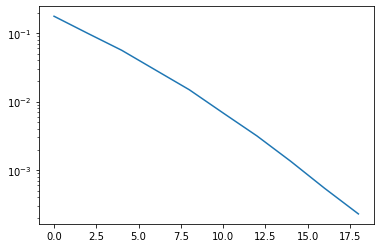

In [ ]:
plt.semilogy(np.arange(0,20,2.0), ber)

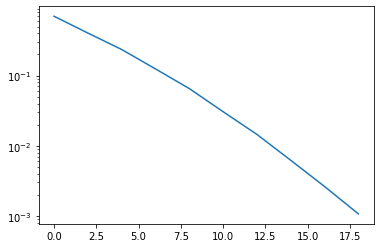

In [ ]:
plt.semilogy(np.arange(0,20,2.0), bler)